In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
train_images = np.load('kuzushiji_mnist/'+'kmnist-train-imgs.npz')['arr_0']
test_images = np.load('kuzushiji_mnist/'+'kmnist-test-imgs.npz')['arr_0']
train_labels = np.load('kuzushiji_mnist/'+'kmnist-train-labels.npz')['arr_0']
test_labels = np.load('kuzushiji_mnist/'+'kmnist-test-labels.npz')['arr_0']

In [4]:
train_images.shape

(60000, 28, 28)

In [5]:
train_labels = train_labels.reshape(-1, 1)
train_labels.shape

(60000, 1)

In [15]:
train_labels[1]

array([7])

In [16]:
train_labels.dtype

dtype('int32')

In [17]:
train_images = np.asarray(train_images, dtype = np.float32)
train_labels = np.asarray(train_labels, dtype = np.int32)
test_images = np.asarray(test_images, dtype = np.float32)
test_labels = np.asarray(test_labels, dtype = np.int32)

Text(0.5, 1.0, 'Classe: [7]')

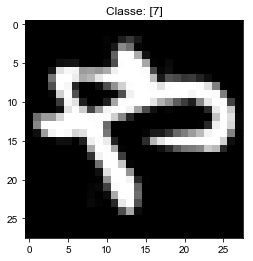

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(train_images[1], cmap = 'gray')
plt.title('Classe: ' + str(train_labels[1]))

In [19]:
char_df = pd.read_csv('kuzushiji_mnist/'+'kmnist_classmap.csv', encoding = 'utf-8')

In [83]:
char_df['char']

0    お
1    き
2    す
3    つ
4    な
5    は
6    ま
7    や
8    れ
9    を
Name: char, dtype: object

In [90]:
def create_network(features, labels, mode):
    input = tf.reshape(features['x'], [-1, 28, 28, 1])
    
    # receives [batch_size, 28, 28, 1]
    # returns [batch_size, 28, 28, 32]
    convolution1 = tf.layers.conv2d(inputs = input, filters = 32, kernel_size = [5,5], activation = tf.nn.relu,
                                 padding = 'same')
    
    # receives [batch_size, 28, 28, 1]
    # returns [batch_size, 14, 14, 32]
    pooling1 = tf.layers.max_pooling2d(inputs = convolution1, pool_size = [2,2], strides = 2)
    
    # receives [batch_size, 14, 14, 32]
    # returns [batch_size, 14, 14, 64]
    convolution2 = tf.layers.conv2d(inputs = pooling1, filters = 64, kernel_size = [5,5], activation = tf.nn.relu,
                                  padding = 'same')
    
    # receives [batch_size, 14, 14, 64]
    # returns [batch_size, 7, 7, 64]
    pooling2 = tf.layers.max_pooling2d(inputs = convolution2, pool_size = [2,2], strides = 2)
    
    # receives [batch_size, 7, 7, 64]
    # returns [batch_size, 3136]
    flattening = tf.reshape(pooling2, [-1, 7 * 7 * 64])
    
    # 3136 inputs -> 1024 neurons on hidden layer -> 10 outputs
    # receives [batch_size, 3136]
    # returns [batch_size, 1024]
    dense = tf.layers.dense(inputs = flattening, units = 1024, activation = tf.nn.relu)
    
    dense2 = tf.layers.dense(inputs = dense, units = 1024, activation = tf.nn.relu)
    
    # dropout
    dropout =  tf.layers.dropout(inputs = dense2, rate = 0.2, training = mode == tf.estimator.ModeKeys.TRAIN)
    
    # receives [batch_size, 1024]
    # returns [batch_size, 10]
    output = tf.layers.dense(inputs = dropout, units = 10)
    
    predictions = tf.argmax(output, axis = 1)
    
    if(mode == tf.estimator.ModeKeys.PREDICT):
        return tf.estimator.EstimatorSpec(mode = mode, predictions = predictions)  
    
    losses = tf.losses.sparse_softmax_cross_entropy(labels = labels, logits = output)
    
    if(mode == tf.estimator.ModeKeys.TRAIN):
        optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
        train = optimizer.minimize(losses, global_step = tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode = mode, loss = losses, train_op = train)
    
    if(mode == tf.estimator.ModeKeys.EVAL):
        eval_metrics_ops = {'accuracy': tf.metrics.accuracy(labels = labels, predictions = predictions)}
        return tf.estimator.EstimatorSpec(mode = mode, loss = losses, eval_metric_ops = eval_metrics_ops)      

In [91]:
classifier = tf.estimator.Estimator(model_fn = create_network)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\diego\\AppData\\Local\\Temp\\tmpzc44yad5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002332706E0B8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [92]:
train_function = tf.estimator.inputs.numpy_input_fn(x = {'x': train_images}, y = train_labels, 
                                                        batch_size= 128, num_epochs= None, shuffle= True)
classifier.train(input_fn = train_function, steps = 2000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\diego\AppData\Local\Temp\tmpzc44yad5\model.ckpt.
INFO:tensorflow:loss = 37.654312, step = 1
INFO:tensorflow:global_step/sec: 1.79837
INFO:tensorflow:loss = 0.39159846, step = 101 (55.608 sec)
INFO:tensorflow:global_step/sec: 1.78625
INFO:tensorflow:loss = 0.43682536, step = 201 (55.983 sec)
INFO:tensorflow:global_step/sec: 1.90871
INFO:tensorflow:loss = 0.2443912, step = 301 (52.426 sec)
INFO:tensorflow:global_step/sec: 1.77169
INFO:tensorflow:loss = 0.2679621, step = 401 (56.407 sec)
INFO:tensorflow:global_step/sec: 1.67856
INFO:tensorflow:loss = 0.063675076, step = 501 (59.576 sec)
INFO:tensorflow:global_step/sec: 1.67009
INFO:tensorflow:loss = 0.22503719, step = 601 (59.914 sec)
INFO:tensorflow:g

In [94]:
test_function = tf.estimator.inputs.numpy_input_fn(x = {'x': test_images}, y = test_labels, num_epochs = 1, shuffle = False)

results = classifier.evaluate(input_fn = test_function)
results

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-21-13:49:56
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\diego\AppData\Local\Temp\tmpzc44yad5\model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-01-21-13:50:09
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9344, global_step = 2000, loss = 0.27803466
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: C:\Users\diego\AppData\Local\Temp\tmpzc44yad5\model.ckpt-2000


{'accuracy': 0.9344, 'loss': 0.27803466, 'global_step': 2000}

In [95]:
x_image_test = test_images[2]
x_image_test = x_image_test.reshape(1,-1)
x_image_test.shape

(1, 784)

In [96]:
prediction_function = tf.estimator.inputs.numpy_input_fn(x = {'x': x_image_test}, shuffle = False)
pred = list(classifier.predict(input_fn = prediction_function))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\diego\AppData\Local\Temp\tmpzc44yad5\model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Text(0.5, 1.0, 'Classe prevista: つ')

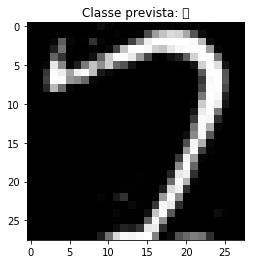

In [97]:
plt.imshow(x_image_test.reshape((28,28)), cmap = 'gray')
plt.title('Classe prevista: ' + str(char_df['char'][pred[0]]))